d:\anaconda3\envs\py310_torch\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Model saved for environment Pendulum-v1 at episode 28
达到收敛条件，提前退出训练


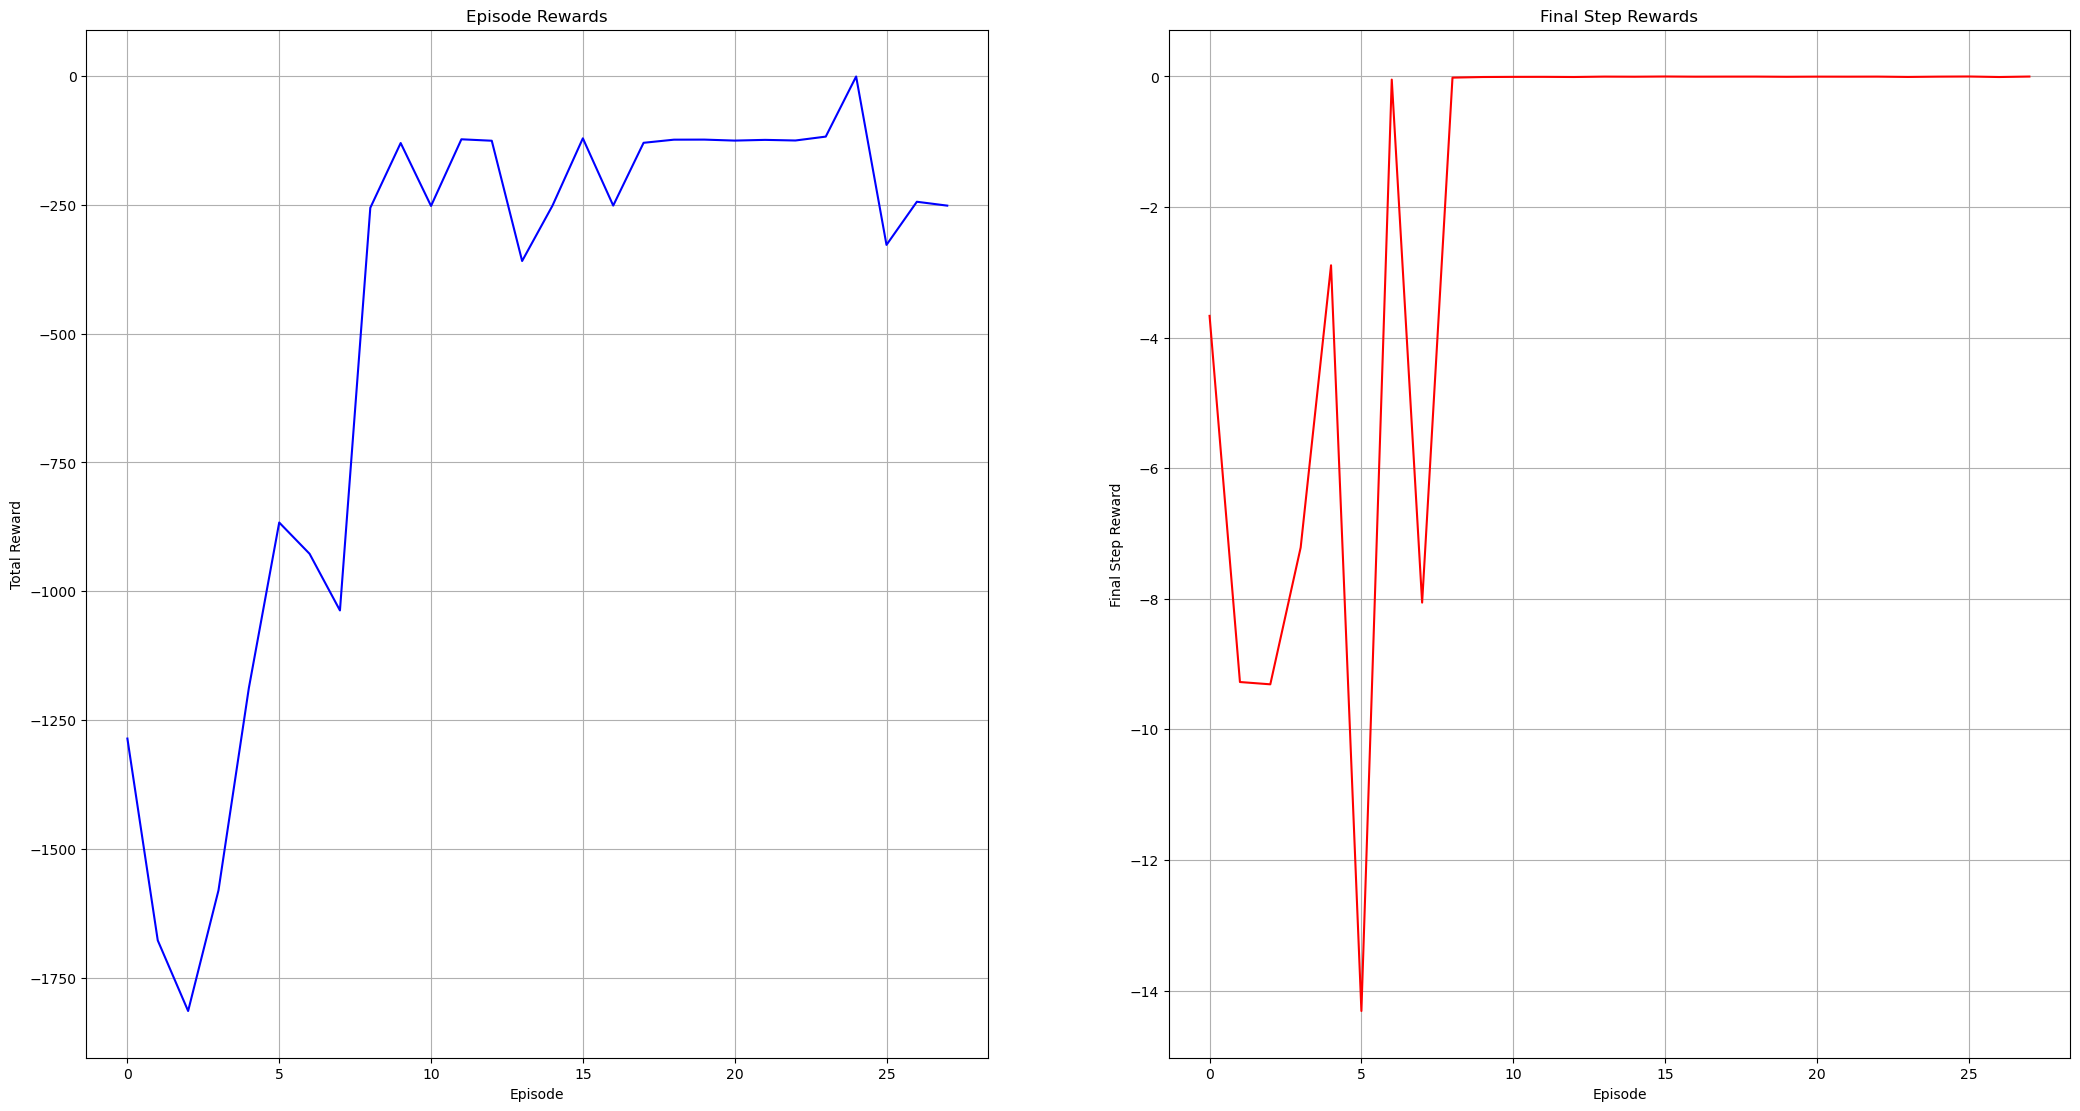

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gym
import random
from collections import deque
import matplotlib.pyplot as plt

# 超参数
BUFFER_SIZE = 100000  # 经验回放缓冲区大小
BATCH_SIZE = 128      # 每次训练的批量大小
GAMMA = 0.99          # 折扣因子
TAU = 0.01           # 目标网络软更新系数
LR_ACTOR = 0.001      # Actor 学习率
LR_CRITIC = 0.002     # Critic 学习率
MAX_EPISODES = 200    # 最大训练回合数
MAX_STEPS = 200       # 每回合最大步数
env_name = "Pendulum-v1"  # 环境名称

# 设备选择
device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.max_action = max_action

        # 定义网络层
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, action_dim)  # 输出均值
        self.fc_log_std = nn.Linear(256, action_dim)  # 输出标准差的对数

    def forward(self, state):
        # 前向传播
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)  # 均值
        log_std = self.fc_log_std(x)  # 标准差的对数
        return mean, log_std

    def greedy_action(self, state):
        # 获取确定性策略的贪心动作
        mean, _ = self.forward(state)
        return torch.tanh(mean) * self.max_action

    def sample(self, state):
        # 从策略中采样动作，并计算对数概率
        mean, log_std = self.forward(state)
        std = log_std.exp()  # 标准差

        # 重参数化技巧：从标准正态分布中采样噪声
        normal = torch.distributions.Normal(mean, std)
        z = normal.rsample()  # 重参数化采样
        action = torch.tanh(z)  # 将动作限制在 [-1, 1] 范围内

        # 计算对数概率
        log_prob = normal.log_prob(z)  # 原始动作的对数概率
        log_prob -= torch.log(1 - action.pow(2) + 1e-6)  # 考虑 tanh 的变换
        log_prob = log_prob.sum(1, keepdim=True)  # 对动作维度求和

        # 将动作缩放到环境允许的范围
        action = action * self.max_action
        return action, log_prob

# Critic 网络
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value

# 经验回放缓冲区
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.FloatTensor(np.array(states)).to(device),            # 形状: (batch_size, state_dim)
            torch.FloatTensor(np.array(actions)).to(device),          # 形状: (batch_size, action_dim)
            torch.FloatTensor(np.array(rewards)).unsqueeze(1).to(device),  # 形状: (batch_size, 1)
            torch.FloatTensor(np.array(next_states)).to(device),      # 形状: (batch_size, state_dim)
            torch.FloatTensor(np.array(dones)).unsqueeze(1).to(device),    # 形状: (batch_size, 1)
        )

    def __len__(self):
        return len(self.buffer)

class SAC:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.critic1 = Critic(state_dim, action_dim).to(device)
        self.critic2 = Critic(state_dim, action_dim).to(device)
        self.critic1_target = Critic(state_dim, action_dim).to(device)
        self.critic2_target = Critic(state_dim, action_dim).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())
        self.critic_optimizer = optim.Adam(list(self.critic1.parameters()) + list(self.critic2.parameters()), lr=LR_CRITIC)

        # 熵正则化系数
        self.alpha = 0.2
        self.target_entropy = -torch.prod(torch.Tensor(action_dim).to(device)).item()
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=LR_ACTOR)

        self.max_action = max_action
        self.replay_buffer = ReplayBuffer(BUFFER_SIZE)

    def select_action(self, state, eval=False):
        """
        选择动作
        :param state: 当前状态
        :param eval: 是否为评估模式（True 时不加噪声）
        :return: 动作
        """
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        if eval:
            # 评估模式：直接使用均值作为动作
            mean, _ = self.actor(state)
            action = torch.tanh(mean) * self.max_action
        else:
            # 训练模式：从策略中采样动作
            action, _ = self.actor.sample(state)
        return action.cpu().data.numpy().flatten()

    def train(self):
        if len(self.replay_buffer) < BATCH_SIZE:
            return
        # 从缓冲区采样
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(BATCH_SIZE)

        # 计算目标 Q 值
        with torch.no_grad():
            next_actions, log_probs = self.actor.sample(next_states)  # 采样下一动作并计算对数概率
            target_q1 = self.critic1_target(next_states, next_actions)
            target_q2 = self.critic2_target(next_states, next_actions)
            target_q = rewards + (1 - dones) * GAMMA * (torch.min(target_q1, target_q2) - self.alpha * log_probs)

        # 更新 Critic 网络
        current_q1 = self.critic1(states, actions)
        current_q2 = self.critic2(states, actions)
        critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # 更新 Actor 网络
        actions, log_probs = self.actor.sample(states)  # 采样动作并计算对数概率
        q1 = self.critic1(states, actions)
        q2 = self.critic2(states, actions)
        actor_loss = (self.alpha * log_probs - torch.min(q1, q2)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新熵正则化系数
        alpha_loss = -(self.log_alpha * (log_probs + self.target_entropy).detach()).mean()

        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        self.alpha = self.log_alpha.exp()

        # 软更新目标网络
        for param, target_param in zip(self.critic1.parameters(), self.critic1_target.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
        for param, target_param in zip(self.critic2.parameters(), self.critic2_target.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)

# 主函数
def main():
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    sacAgent = SAC(state_dim, action_dim, max_action)

    # qt弹窗显示
    %matplotlib qt
    # 初始化动态绘图
    plt.ion()  # 开启交互模式
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.set_title("Episode Rewards")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Total Reward")
    line1, = ax1.plot([], [], color="blue")
    ax1.grid(True)
    ax2.set_title("Final Step Rewards")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Final Step Reward")
    line2, = ax2.plot([], [], color="red")
    ax2.grid(True)

    episode_rewards = []  # 存储每个回合的总奖励
    final_step_rewards = []  # 存储每个回合的最后一步奖励

    # 监控参数
    success_count = 0

    for episode in range(MAX_EPISODES):
        state = env.reset()[0]
        episode_reward = 0
        final_reward = 0

        for step in range(MAX_STEPS):
            action = sacAgent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            sacAgent.replay_buffer.add(state, action, reward, next_state, 0) # 游戏没有终止状态，所以dones为0
            state = next_state
            episode_reward += reward
            final_reward = reward  # 记录最后一步的奖励

            sacAgent.train()

            if done:
                break

        episode_rewards.append(episode_reward)
        final_step_rewards.append(final_reward)

        #print(f"Episode: {episode + 1}, Total Reward: {episode_reward}, Final Step Reward: {final_reward}")

        # 更新图像
        line1.set_data(range(len(episode_rewards)), episode_rewards)
        ax1.relim()
        ax1.autoscale_view()
        line2.set_data(range(len(final_step_rewards)), final_step_rewards)
        ax2.relim()
        ax2.autoscale_view()

        plt.pause(0.025)  # 短暂暂停以更新图像

        # 监控训练过程，视情况提前退出，并保存模型
        if episode_reward > -400:
            success_count += 1
            if success_count >= 20 and final_reward > -0.001:
                # 保存模型：环境名称+模型名称
                torch.save(sacAgent.actor.state_dict(), f"{env.spec.id}_SAC_actor.pth")
                torch.save(sacAgent.critic1.state_dict(), f"{env.spec.id}_SAC_critic1.pth")
                torch.save(sacAgent.critic2.state_dict(), f"{env.spec.id}_SAC_critic2.pth")
                print(f"Model saved for environment {env.spec.id} at episode {episode + 1}")
                print(f"达到收敛条件，提前退出训练")
                break
        else:
            success_count = 0


    plt.ioff()  # 关闭交互模式
    # 重新设置为行内显示
    %matplotlib inline
    plt.show()
    env.close()

if __name__ == "__main__":
    main()

d:\anaconda3\envs\py310_torch\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


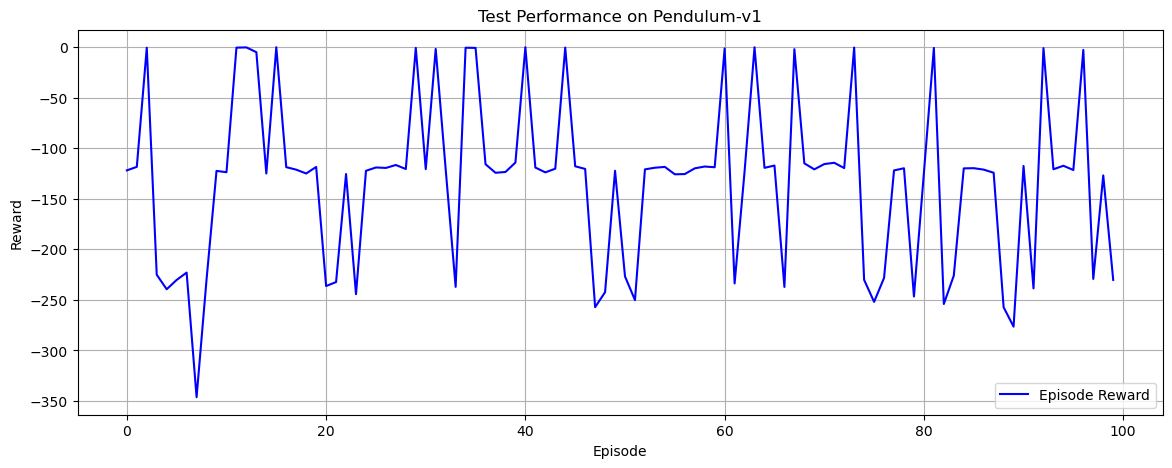

In [2]:
import pygame
# 加载模型
def load_model(env_name, state_dim, action_dim, max_action):
    actor = Actor(state_dim, action_dim, max_action).to(device)
    actor.load_state_dict(torch.load(f"{env_name}_SAC_actor.pth", weights_only=True))
    actor.eval()  # 设置为评估模式
    return actor

# 测试函数
def test_model(env_name, test_episodes, max_steps, render_mode=None):
    env = gym.make(env_name, render_mode=render_mode)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    # 加载训练好的 Actor 模型
    actor = load_model(env_name, state_dim, action_dim, max_action)

    episode_rewards = []  # 存储每个回合的奖励
    rewards_history = []  # 存储每个回合的奖励历史

    bExit = False

    for episode in range(test_episodes):
        state = env.reset()[0]
        episode_reward = 0
        rewards_history.append([])

        for step in range(max_steps):
            # 选择动作（无探索噪声）
            state_tensor = torch.FloatTensor(state.reshape(1, -1)).to(device)
            action = actor.greedy_action(state_tensor)
            action = action.cpu().data.numpy().flatten()

            # 执行动作
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            rewards_history[episode].append(reward)
            state = next_state

            if done:
                break

            if render_mode == "human":
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        bExit = True
                    # 按下esc键退出
                    if event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_ESCAPE:
                            bExit = True

        episode_rewards.append(episode_reward)
        #print(f"Test Episode: {episode + 1}, Reward: {episode_reward}")
        if bExit:
            print(f"按下ESC, 提前退出测试")
            break

    env.close()

    # 绘制回合奖励图像
    plt.figure(figsize=(14, 5))
    plt.plot(episode_rewards, color="blue", label="Episode Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(f"Test Performance on {env_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return rewards_history

# 主函数
if __name__ == "__main__":
    rewards_history = test_model(env_name, 100, MAX_STEPS, render_mode=None) # render_mode=None 表示不渲染, render_mode="human" 表示渲染

In [3]:
# 绘制奖励曲线
%matplotlib qt
plt.plot(rewards_history[0])
plt.xlabel('Step')
plt.ylabel('Reward')
# 网格线
plt.grid(True)
plt.show()

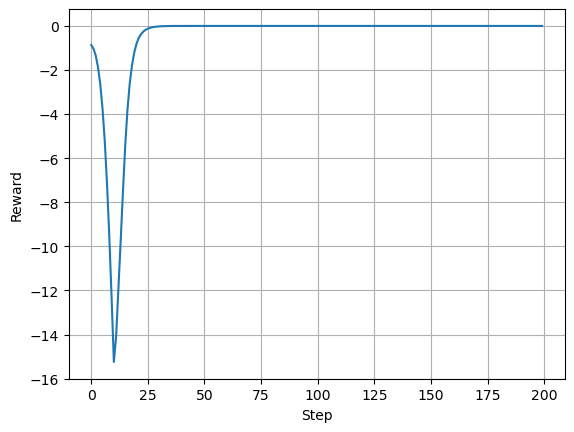

In [4]:
# 绘制奖励曲线
%matplotlib inline
plt.plot(rewards_history[0])
plt.xlabel('Step')
plt.ylabel('Reward')
# 网格线
plt.grid(True)
plt.show()